In [1]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import os
import hashlib
import pydicom
from pymongo import *
import skimage.io
from glob import glob
from datetime import datetime
from PIL import Image

In [2]:
DICOM_PATH = 'data/dicom_dir/'
JPEG_PATH = 'data/jpeg_dir/'

DICOM_FILES_PATH = os.path.join(DICOM_PATH, '*.dcm') 
dicom_data = pd.DataFrame([{'path': filepath} for filepath in glob(DICOM_FILES_PATH)]) 

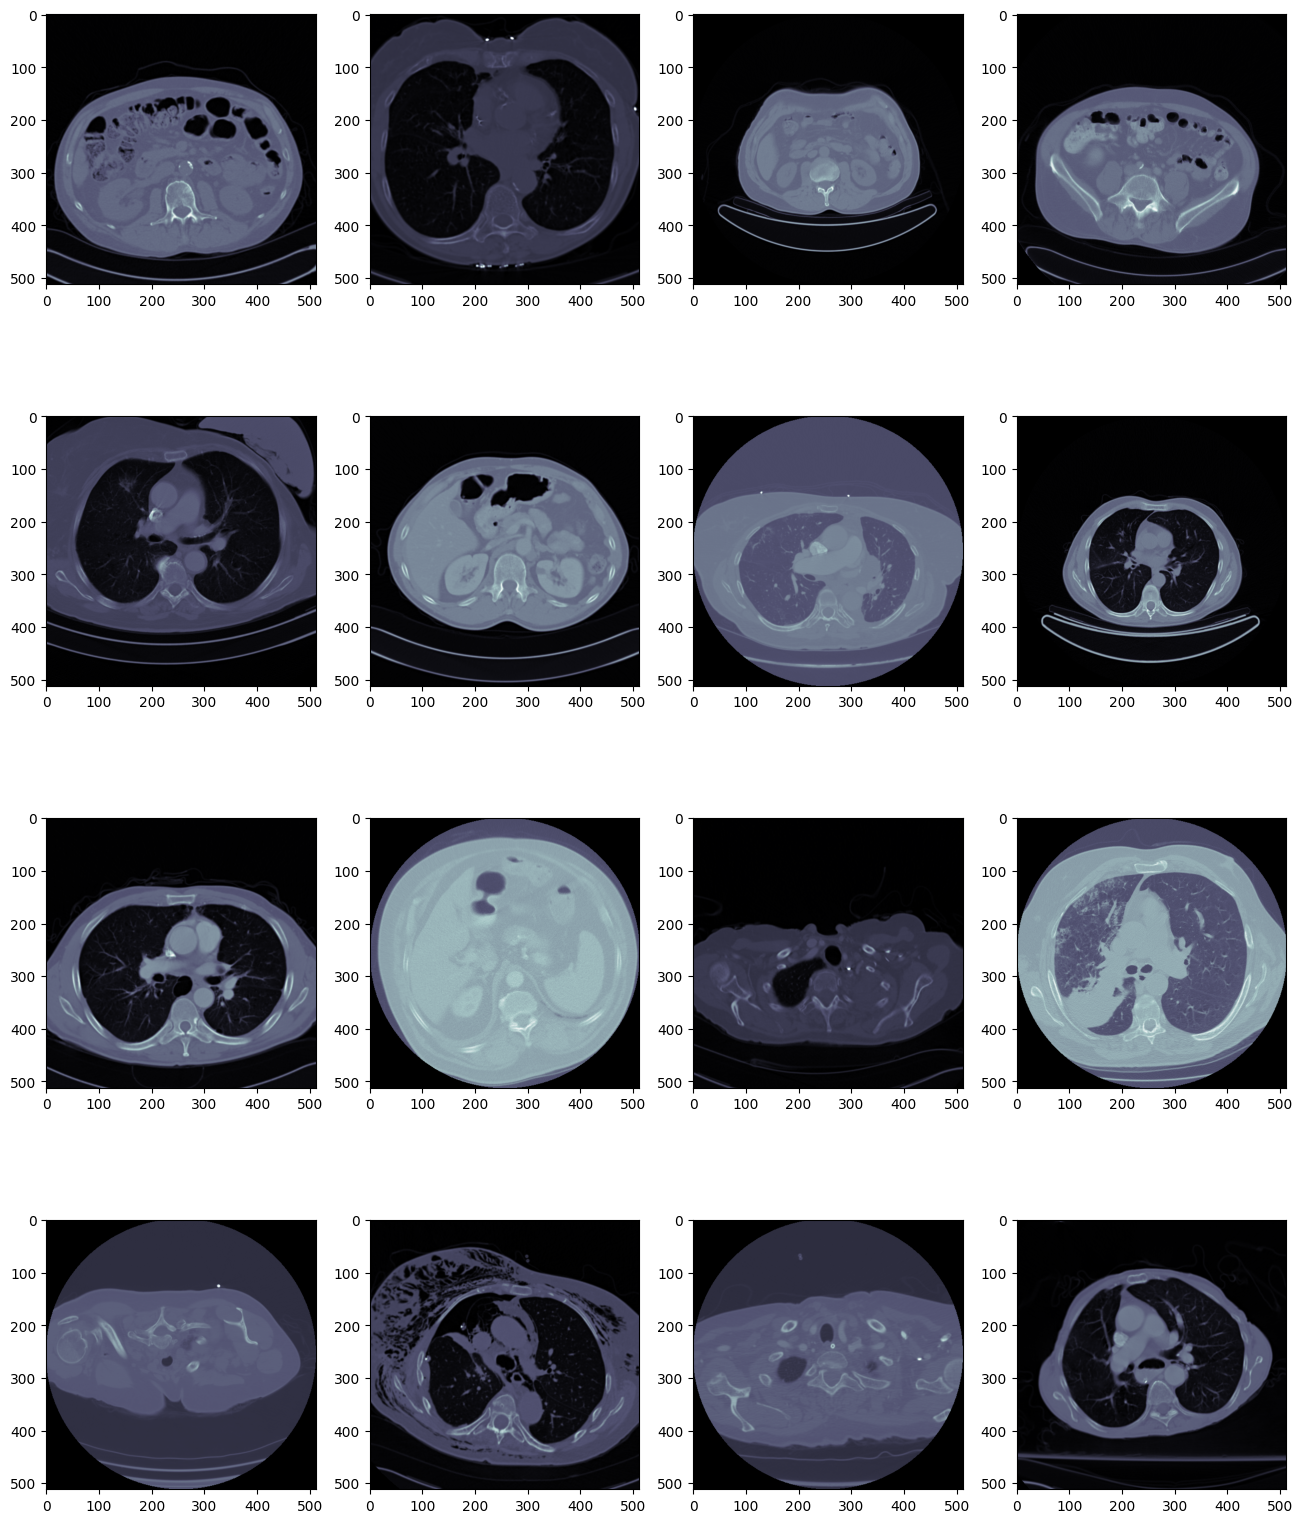

In [3]:
dicom_data['file'] = dicom_data['path'].map(os.path.basename) 
 
# Show 16 DICOM images in a 4x4 grid  
img_data = list(dicom_data[:16].T.to_dict().values()) 
f, ax = plt.subplots(4,4, figsize=(16,20)) 
for i,data_row in enumerate(img_data): 
    data_row_img = pydicom.dcmread(data_row['path']) 
    ax[i//4, i%4].imshow(data_row_img.pixel_array, cmap=plt.cm.bone)  
     
plt.show() 

In [4]:
dicom_file_path = list(dicom_data[:1].T.to_dict().values())[0]['path'] 
dicom_file_metadata = pydicom.dcmread(dicom_file_path) 
#print(dicom_file_metadata) 

In [5]:
# In principle, DICOM ages could be in days, weeks, etc. We check that
# the database only contains ages in 'Y'
for idx in range(len(dicom_data)):
    ds_path = list(dicom_data[:].T.to_dict().values())[idx]['path']
    ds = pydicom.dcmread(ds_path)
    age = ds.get((0x0010, 0x1010)).value
    if age[-1:] != 'Y':
        print(f'Age in {age[-1:]}')

## Transform DICOM metadata and images

In [6]:
def surrogate_key(values):
    """
    Generates a unique MD5 hash string for a dictionary.
    
    Args:
        values (dict): Dictionary to convert into hash.
        
    Returns:
        str: Hash string.
    """
    # Sort the dictionary items to ensure a consistent order
    sorted_items = sorted(values.items())
    string_representation = str(sorted_items)
    
    # Encode the string to bytes
    encoded_string = string_representation.encode('utf-8')
    # Create and update the MD5 hash object
    md5_hash = hashlib.md5()
    md5_hash.update(encoded_string)
    
    return md5_hash.hexdigest()

def format_age(age_str):
    """
    Transforms a DICOM age string (e.g., '061Y') into an integer
    (e.g., 61). 
    """
    # Handle missing data
    if not age_str:
        return -1

    try:
        # This supposes all the ages are in years 'Y', as in the given dataset
        return int(age_str[:-1])
    except ValueError:
        # Catch cases where the formatting is incorrect
        return -1

def dicom_to_jpeg(input_path, output_dir, size=(256, 256)):
    """
    Reads a DICOM file, normalizes pixel values, resizes it, and saves it as a 
    grayscale JPEG, returning the new file path.
    """
    try:
        ds = pydicom.dcmread(input_path)
        pixel_array = ds.pixel_array
        
        min_val = pixel_array.min()
        max_val = pixel_array.max()
        
        if max_val == min_val:
            # All pixels have the same value
            normalized_array = np.zeros(pixel_array.shape, dtype=np.uint8)
        else:
            # Normalize (0 to 1) and scale to (0 to 255)
            normalized_array = ((pixel_array - min_val) / (max_val - min_val)) * 255
            normalized_array = normalized_array.astype(np.uint8)

        os.makedirs(output_dir, exist_ok=True)

        # Get output path
        input_filename = os.path.basename(input_path).split('.')[0]
        output_filename = f"{input_filename}_{size[0]}x{size[1]}.jpeg"
        output_path = os.path.join(output_dir, output_filename)
        os.makedirs(output_dir, exist_ok=True)

        # Create 2D PIL Image object
        # As noramlized_array is a 2D array PIL interprets grayscale
        image = Image.fromarray(normalized_array)
        resized_image = image.resize(size)

        # Save image as JPEG
        resized_image.save(output_path, 'JPEG', quality=95)
        
        #print(f"Successfully converted and saved to: {output_path}")
        return output_path
        
    except Exception as e:
        print(f"ERROR converting DICOM {input_path} to JPEG: {e}")
        return None

def normalize_pixel_spacing(raw_value):
    """
    Rounds a numeric pixel spacing value to the nearest bin within a predefined set.
    """
    BINS = [0.6, 0.65, 0.7, 0.75, 0.8]
    try:
        value = float(raw_value)
        
        # Find the bin with the minimum absolute difference
        closest_bin = min(BINS, key=lambda bin_val: abs(value - bin_val))
        
        return closest_bin
    except ValueError:
        # In case the metadata tag is missing
        return -1

def normalize_contrast_agent(val):
    """
    Standardizes DICOM contrast agent metadata.
    Replaces missing, empty, or single-character values with "No contrast agent".
    Otherwise, returns the cleaned string.
    """
    if val is None:
        return "No contrast agent"
    
    val = str(val).strip()
    
    if not val or len(val) <= 1:
        return "No contrast agent"
        
    return val

def get_or_create(collection, values, pk_name):
    """
    Check if a record exists in a MongoDB collection, if it does not exist insert
    a new one using the surrogate key as a primary key. Returns the surrogate key
    in both cases.

    Args:
        collection (pymongo.collection.Collection): PyMongo Collection object to interface with
                                                    a specific table.
        values (dict): Dictionary containing the attributes of the dimension record.
        pk_name (str): The name of the surrogate key field that will be used as primary
                       key in MongodDB.
        
    Returns:
        str: Hash string.  
    """
    # Calculate the surrogate key
    sk = surrogate_key(values)

    # Filter for the database lookup
    lookup_filter = {pk_name: sk}

    # Check for existence
    existing_document = collection.find_one(lookup_filter)
    
    if existing_document:
        return sk
    else:
        # Document to be inserted
        document = values.copy()
        document[pk_name] = sk

        collection.insert_one(document)
        return sk
        
def safe_get_value(ds, tag):
    element = ds.get(tag, None)
    return element.value if element else None

## MongoDB functions

In [7]:
# Database configuration
MONGO_URI = "mongodb://localhost:27017"
DB_NAME = "medical_imaging"
DICOM_PATH = 'data/dicom_dir/'
JPEG_PATH = 'data/jpeg_dir/'
DICOM_FILES_PATTERN = os.path.join(DICOM_PATH, "*.dcm")

In [8]:
# Connect to MongoDB
client = MongoClient(MONGO_URI)
# Ping to check the connection
try:
    client.admin.command('ping')
    print("Successfully connected to MongoDB!")
except Exception as e:
    print(e)

Successfully connected to MongoDB!


In [9]:
def load_dim_patient(ds, dim_patient):
    # Extract data
    #patient_id = safe_get_value(ds, (0x0010, 0x0020))
    sex = safe_get_value(ds, (0x0010, 0x0040))
    age_str = safe_get_value(ds, (0x0010, 0x1010)) 
    age_int = format_age(age_str) 
    
    # Dictionary for key generation/insertion
    patient_values = {
        #"patient_id": patient_id,
        "sex": sex,
        "age": age_int
    }
    
    # Load and Get Surrogate Key
    patient_sk = get_or_create(dim_patient, patient_values, pk_name="patient_sk")
    return patient_sk

def load_dim_station(ds, dim_station):
    manufacturer = safe_get_value(ds, (0x0008,0x0070))
    model = safe_get_value(ds, (0x0008,0x1090))

    station_values = {
        "manufacturer": manufacturer,
        "model": model
    }
    
    station_sk = get_or_create(dim_station, station_values, pk_name="station_sk")
    return station_sk

def load_dim_protocol(ds, dim_protocol):
        
    body_part = safe_get_value(ds, (0x0018, 0x0015))
    contrast_agent_val = safe_get_value(ds, (0x0018, 0x0010))
    patient_position = safe_get_value(ds, (0x0018, 0x5100))

    contrast_agent = normalize_contrast_agent(contrast_agent_val)

    protocol_values = {
        "body_part": body_part,
        "contrast_agent": contrast_agent,
        "patient_position": patient_position,
    }
    
    protocol_sk = get_or_create(dim_protocol, protocol_values, pk_name="protocol_sk")
    return protocol_sk
    
def load_dim_date(ds, dim_date):
    
    date_str = safe_get_value(ds, (0x0008, 0x0022))

    if not date_str:
        # If date is missing, use -1 for year/month, and None for ID
        date_values = {"year": -1, "month": -1} 
    else:
        try:
            # Parse the YYYYMMDD string into a datetime object
            date_obj = datetime.strptime(date_str, '%Y%m%d') 
            
            date_values = {
                "year": date_obj.year,
                "month": date_obj.month
            }
        except ValueError:
            # Catch malformed strings
            date_values = {"year": -1, "month": -1} 

    date_sk = get_or_create(dim_date, date_values, pk_name="date_sk")
    return date_sk


def load_dim_image(ds, dim_image):
    """
    Safely extracts image-specific metadata, applies transformations,
    and loads the record into the IMAGE dimension table.
    
    Args:
        ds (pydicom.Dataset): The pydicom object for the current file.
        dim_image (pymongo.collection.Collection): The MongoDB IMAGE dimension collection.
        
    Returns:
        str: The image_sk (surrogate key) for the loaded dimension record.
    """
    
    # Extract image attributes
    rows_val = safe_get_value(ds, (0x0028, 0x0010))
    columns_val = safe_get_value(ds, (0x0028, 0x0011))
    pixel_spacing_val = safe_get_value(ds, (0x0028, 0x0030))
    slice_thickness_val = safe_get_value(ds, (0x0018, 0x0050))
    photometric_interp_val = safe_get_value(ds, (0x0028, 0x0004))
    
    # Transformation
    if hasattr(pixel_spacing_val, '__len__') and len(pixel_spacing_val) >= 2:
        ps_x_raw = str(pixel_spacing_val[0])
        ps_y_raw = str(pixel_spacing_val[1])   
    elif pixel_spacing_val is not None:
        ps_x_raw = ps_y_raw = str(pixel_spacing_val)

    # Apply the normalization helper function to bin the spacing values
    ps_x_clean = normalize_pixel_spacing(ps_x_raw) 
    ps_y_clean = normalize_pixel_spacing(ps_y_raw)

    image_values = {
        "rows": rows_val,
        "columns": columns_val,
        "pixel_spacing_x": ps_x_clean,
        "pixel_spacing_y": ps_y_clean,
        "slice_thickness": slice_thickness_val,
        "photometric_interp": photometric_interp_val,
    }
    
    # Load and get the surrogate key
    image_sk = get_or_create(dim_image, image_values, pk_name="image_sk")
    return image_sk

def load_fact_study(file_path, fact_study, dim_patient, dim_station, dim_protocol, dim_date, dim_image):
    """
    Orchestrates the ETL process for a single DICOM file:
    1. Reads the DICOM file.
    2. Loads dimension records and retrieves their surrogate keys (SKs).
    3. Extracts remaining fact data and constructs the fact document.
    4. Inserts the fact document into the fact table.

    Args:
        file_path (str): Full path to the DICOM file.
        fact_study (pymongo.collection.Collection): MongoDB fact table collection.
        dim_patient, dim_station, etc. (pymongo.collection.Collection): Dimension collections.
    """
    try:
        ds = pydicom.dcmread(file_path)
        
        # Load dimension tables and retrieve surrogate keys
        patient_sk = load_dim_patient(ds, dim_patient)
        station_sk = load_dim_station(ds, dim_station)
        protocol_sk = load_dim_protocol(ds, dim_protocol)
        date_sk = load_dim_date(ds, dim_date)
        image_sk = load_dim_image(ds, dim_image)

        # Extract fact data
        exposure_time = safe_get_value(ds, (0x0018, 0x1150))
        tube_current = safe_get_value(ds, (0x0018, 0x1151))

        # The relative path to the JPEG file
        jpeg_path = dicom_to_jpeg(file_path, JPEG_PATH)
        if not JPEG_PATH:
            # Skip the process for this file if image conversion failed
            print(f"Skipping fact load for {os.path.basename(file_path)}: JPEG conversion failed.")
            return

        study_values = {
            # FOREIGN KEYS (Surrogate Keys from dimensions)
            "station_sk": station_sk,
            "patient_sk": patient_sk,
            "image_sk": image_sk,
            "protocol_sk": protocol_sk,
            "study_date": date_sk,
            
            # MEASURES / ATTRIBUTES
            "exposure_time": exposure_time,
            "tube_current": tube_current,
            "file_path": jpeg_path
        }
        # Load the fact table
        image_sk = get_or_create(fact_study, study_values, pk_name="study_sk")
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

In [10]:
def run_etl_pipeline():
    """
    Connects to MongoDB, defines collections, and runs the ETL process 
    for all DICOM files.
    """
    print(f"Connecting to MongoDB at: {MONGO_URI}")
    client = None # Initialize client outside try block
    
    try:
        # Establish Connection
        client = MongoClient(MONGO_URI)
        client.admin.command('ping')
        print("Successfully connected to MongoDB.")

        # Define Database and Collections
        db = client[DB_NAME]
        
        # Fact Table
        fact_study = db["fact_study"] 
        
        # Dimension Tables
        dim_patient = db["dim_patient"]
        dim_station = db["dim_station"]
        dim_protocol = db["dim_protocol"]
        dim_date = db["dim_date"]
        dim_image = db["dim_image"]

        # Find DICOM Files
        dicom_file_paths = glob(DICOM_FILES_PATTERN)
        total_files = len(dicom_file_paths)
        print(f"Found {total_files} DICOM files to process.")
        
        # 4. Iterate and Load (The main pipeline loop)
        for i, file_path in enumerate(dicom_file_paths):
            load_fact_study(
                file_path, 
                fact_study, 
                dim_patient, 
                dim_station, 
                dim_protocol, 
                dim_date, 
                dim_image
            )
            if (i + 1) % 50 == 0:
                print(f"--- Processed {i + 1} of {total_files} files. ---")

        print("ETL pipeline completed successfully.")

    except Exception as e:
        print(f"FATAL ERROR: Pipeline failed")
        print(e)
        
    finally:
        if client:
            client.close()
            print("MongoDB connection closed.")

In [11]:
run_etl_pipeline()

Connecting to MongoDB at: mongodb://localhost:27017
Successfully connected to MongoDB.
Found 100 DICOM files to process.
--- Processed 50 of 100 files. ---
--- Processed 100 of 100 files. ---
ETL pipeline completed successfully.
MongoDB connection closed.
